In [73]:
# Preamble  here, add paths and import relevant modules
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))
import os,sys,util,numpy as np, sklearn, graph_cluster as gc, data
reload(util)
reload(data)
reload(gc)
from sklearn import datasets
from scipy.sparse.linalg import eigsh
from numpy.random import permutation
% matplotlib inline
import matplotlib.pyplot as plt

# Tutorial 2 --- Testing on MNIST

In this tutorial, we'll deal with some more realistic datasets. We first try our luck with the `MNIST` dataset. The `util` module has a function that reads the raw MNIST data digits

## 2.1 Mini-MNIST (4-9 classification)

We'll first demonstrate the functions on a binary classification problem. The digits 4,9 are chosen because it is among the hardest pairs to cluster. 

In [28]:
gpath = '/'.join(os.getcwd().split('/')[:-1])
raw_data, labels = data.read_mnist(digits = [4,9],path = gpath+'/data')
raw_data = raw_data/255.
full_data, full_labels = data.read_mnist(digits = range(10),path = gpath+'/data')
full_data = full_data/255.

To speed things up, we sample 750 points from each of the digits. We'll construct a weighted `k-nearest neighbors` graph using the `rbf` kernel and see 

In [29]:
sample_data,sample_labels = data.subsample(sample_num = 750, rd = raw_data, labels = labels)

We do a preliminary `PCA` with 50 principal components for the digits at hand and build the graph as before. This was suggested in the Huiyi's paper for modularity optimization. 

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
pca.fit(full_data)
train_data = pca.transform(sample_data)

Finally, we import the graph class and construct the graph as before. The graph is constructed using the `Zelnik-Manor and Perona` kernel, i.e., weighting the variance in the `rbf` kernel by the $k$-th nearest neighbor distance. We plot the corresponding spectral embeddings. 

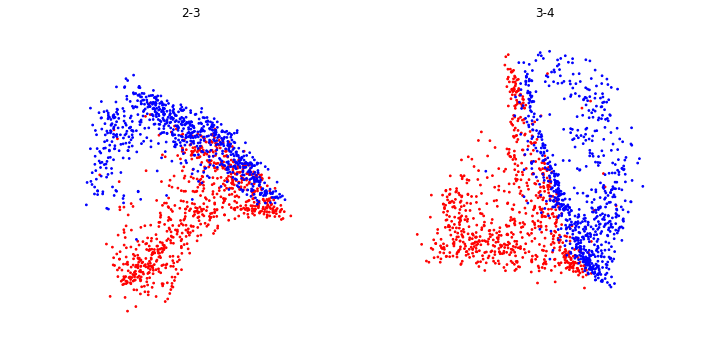

In [75]:
reload(gc)
reload(util)
from graph_cluster import LaplacianClustering
clf = LaplacianClustering(scheme_type = 'MBO_fidelity', eta = 2, dt = 1) # build scheme
clf.load_data(raw_data = train_data, ground_truth = sample_labels) # load data
clf.build_graph(Eig_solver = 'arpack',affinity = 'z-p', n_neighbors = 10 ,Neig = 50,Laplacian_type = 'n')#build graph
V = clf.graph.laplacian_matrix_['V']
plt.subplot(121)
plt.scatter(V[:,1], V[:,2],s=3, color = 750*'r'+750*'b')
plt.title('2-3')
plt.axis('off')
plt.subplot(122)
plt.scatter(V[:,2], V[:,3],s=3, color = 750*'r'+750*'b')
plt.title('3-4')
plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 5)
plt.tight_layout()  
plt.show()  

The decision boundaries certainly seem somewhat more non-linear and compact than before. Let's try the MBO fidelity scheme on it. The results are plotted on the 2-3 eigenvector projection above. 

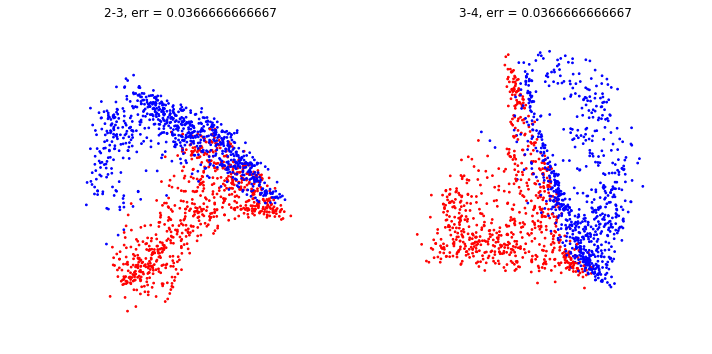

In [77]:
clf.generate_initial_value()
clf.generate_random_fidelity(percent = 0.06)
clf.fit_predict()
palet = 'rb'
colors = [palet[c] for c in util.to_standard_labels(clf.labels_)]
plt.subplot(121)
plt.scatter(V[:,1], V[:,2],s=3, color = colors)
plt.title('2-3, err = {err}'.format(err = clf.compute_error_rate()))
plt.axis('off')
plt.subplot(122)
plt.scatter(V[:,2], V[:,3],s=3, color = colors)
plt.title('3-4, err = {err}'.format(err = clf.compute_error_rate()))
plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 5)
plt.tight_layout()  
plt.show()  

The average performance seems to be $5$ percent error using only $3$ percent fidelity. This again illustrates that the *Graph-Cut* + *Fidelity* method is more of a semi-supervised learning. It works best when the data itself is almost clustered, but a little push along the right direction helps a long way.  

## 2.2 Multiclass classification 

We'll demonstrate multiclass classification by using more digits. We first extract the digits as before. 

In [79]:
reload(data)
raw_data, labels = data.read_mnist(digits = [4,5,9],path = gpath+'/data') 
raw_data = raw_data/255.
sample_data,sample_labels = data.subsample(sample_num = 750, rd = raw_data, labels = labels)
train_data = pca.transform(sample_data)
from graph_cluster import LaplacianClustering
clf = LaplacianClustering(scheme_type = 'MBO_fidelity', eta = 2, n_class = 3)
clf.load_data(raw_data = train_data, ground_truth = sample_labels)

Construct the graph, and plot the eigenvalues to check validity of the graph

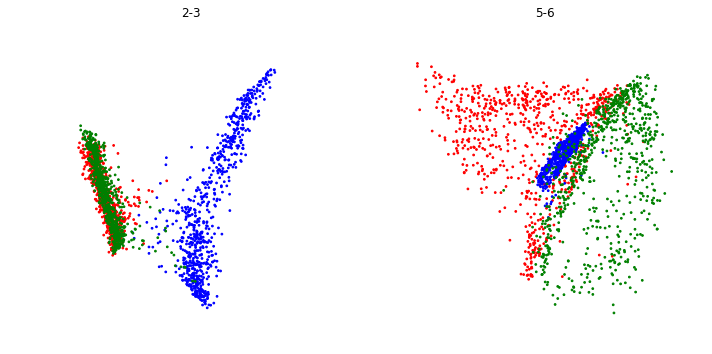

In [81]:
clf.build_graph(affinity = 'z-p',Eig_solver = 'arpack', n_neighbors = 15 ,Neig = 50,Laplacian_type = 'n')
V = clf.graph.laplacian_matrix_['V']
plt.subplot(121)
plt.scatter(V[:,1], V[:,2],s=3, color = 750*'r'+750*'b'+750*'g')
plt.title('2-3')
plt.axis('off')
plt.subplot(122)
plt.scatter(V[:,4], V[:,5],s=3, color = 750*'r'+750*'b'+750*'g')
plt.title('5-6')
plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 5)
plt.tight_layout()  
plt.show()  

Again, Let's try out MBO with fidelity on this. 

u_init dimension not matching n_class. Possiblly out of date. Generating new one


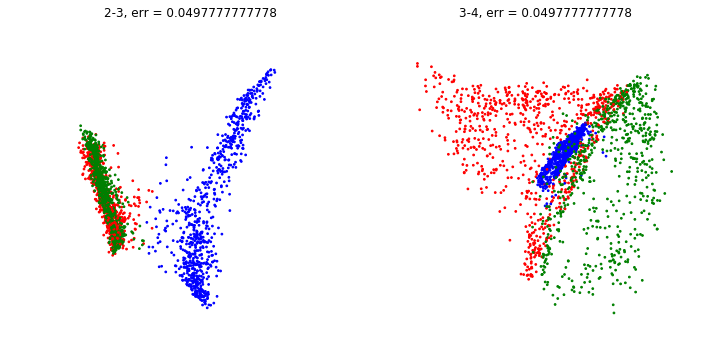

In [85]:
reload(gc)
clf.generate_initial_value()
clf.generate_random_fidelity(percent = 0.06)
clf.fit_predict()
palet = 'rbg'
colors = [palet[c] for c in util.to_standard_labels(clf.labels_)]
plt.subplot(121)
plt.scatter(V[:,1], V[:,2],s=3, color = colors)
plt.title('2-3, err = {err}'.format(err = clf.compute_error_rate()))
plt.axis('off')
plt.subplot(122)
plt.scatter(V[:,4], V[:,5],s=3, color = colors)
plt.title('3-4, err = {err}'.format(err = clf.compute_error_rate()))
plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 5)
plt.tight_layout()  
plt.show()  

Finally, our models can actually perform unsupervised clustering. We will try out Huiyi's MBO_Modularity scheme. The scheme uses graph MBO techniques to approximately solve a "Modularity" criterion, which is more sophisticated than the spectral clustering energy. 

In [93]:
reload(gc)
from graph_cluster import LaplacianClustering
raw_data, labels = data.read_mnist(digits = [4,5,9],path = gpath+'/data') 
raw_data = raw_data/255.
sample_data,sample_labels = data.subsample(sample_num = 750, rd = raw_data, labels = labels)
train_data = pca.transform(sample_data)

u_init not provided. Generating random initial condition.


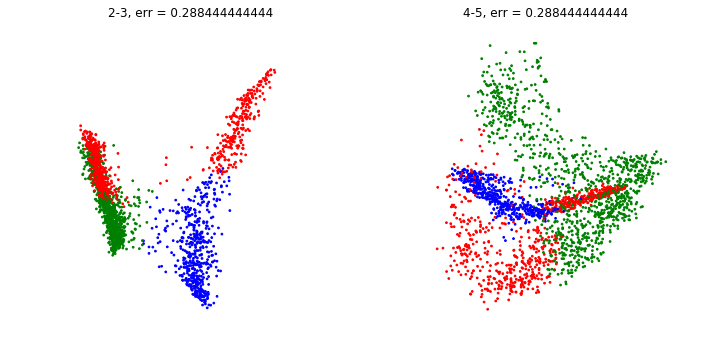

In [136]:
clf = LaplacianClustering(scheme_type = 'MBO_modularity', n_class = 3, gamma = 1, dt = 1)
clf.load_data(raw_data = train_data, ground_truth = sample_labels)
clf.build_graph(Eig_solver = 'arpack',affinity = 'z-p',
                n_neighbors = 15 ,Neig = 50,Laplacian_type = 'n')
clf.fit_predict()
palet = 'rbg'
colors = [palet[c] for c in util.to_standard_labels(clf.labels_)]
plt.subplot(121)
V = clf.graph.laplacian_matrix_['V']
plt.scatter(V[:,1], V[:,2],s=3, color = colors)
plt.title('2-3, err = {err}'.format(err = clf.compute_error_rate()))
plt.axis('off')
plt.subplot(122)
plt.scatter(V[:,3], V[:,4],s=3, color = colors)
plt.title('4-5, err = {err}'.format(err = clf.compute_error_rate()))
plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 5)
plt.tight_layout()  
plt.show() 